In [2]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import math
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, \
                  array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
import seaborn as sns
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import sklearn
from sklearn.decomposition import PCA
import itertools
import mdtraj as md


This is a one millsecond trajectory of ubiquitin generated from DEShaw Research:

https://pubs.acs.org/doi/abs/10.1021/acs.jpcb.6b02024

Trajectory from DESRES can be downloaded here:
https://www.dropbox.com/s/qk4winh3y66bynm/ubq.desres.s500.zip?dl=0

It can be compared to an NMR ensmeble:
https://www.wwpdb.org/pdb?id=pdb_00002kox

In [5]:
pdb='./ubq.desres.s500/ubq.pdb'
trajectory='./ubq.desres.s500/ubq.desres.s500.dcd'
outdir='/ubq.desres.s500/out'

if not os.path.exists('outdir'):
    os.makedirs('outdir')
    
print("outdir:",outdir)
print("pdb:",pdb)
print("trjaectory:",trajectory)

outdir: /ubq.desres.s500/out
pdb: ./ubq.desres.s500/ubq.pdb
trjaectory: ./ubq.desres.s500/ubq.desres.s500.dcd


In [6]:
trj = md.load(trajectory, top=pdb,stride=1)
trj.center_coordinates()
top = trj.topology
first_frame = 0
last_frame = trj.n_frames
n_frames=trj.n_frames

In [7]:
nres=[]
for res in trj.topology.residues: nres.append(res.resSeq)
sequence=(' %s' % [residue for residue in trj.topology.residues])
resname=(' %s' % [residue.name for residue in trj.topology.residues])
resindex=(' %s' % [residue.index for residue in trj.topology.residues])
res_num=(' %s' % [residue.resSeq  for residue in trj.topology.residues])



#log = open("/Users/paulrobustelli/Desktop/Sa_calc.log", "w")
print("** SYSTEM INFO **\n")
print("Number of atoms: %d\n" % trj.n_atoms)
print("Number of residues: %d\n" % len(set(nres)))
print("Number of frames: %d\n" % trj.n_frames)
print("Starting frame: %d\n" % first_frame)
print("Last frame: %d\n" % last_frame)
print("sequence: %s\n" % sequence)
print("residue names: %s\n" % resname)
print("residue number: %s\n" % res_num)
print("residue index: %s\n" % resindex)


** SYSTEM INFO **

Number of atoms: 1231

Number of residues: 76

Number of frames: 10088

Starting frame: 0

Last frame: 10088

sequence:  [MET1, GLN2, ILE3, PHE4, VAL5, LYS6, THR7, LEU8, THR9, GLY10, LYS11, THR12, ILE13, THR14, LEU15, GLU16, VAL17, GLU18, PRO19, SER20, ASP21, THR22, ILE23, GLU24, ASN25, VAL26, LYS27, ALA28, LYS29, ILE30, GLN31, ASP32, LYS33, GLU34, GLY35, ILE36, PRO37, PRO38, ASP39, GLN40, GLN41, ARG42, LEU43, ILE44, PHE45, ALA46, GLY47, LYS48, GLN49, LEU50, GLU51, ASP52, GLY53, ARG54, THR55, LEU56, SER57, ASP58, TYR59, ASN60, ILE61, GLN62, LYS63, GLU64, SER65, THR66, LEU67, HIS68, LEU69, VAL70, LEU71, ARG72, LEU73, ARG74, GLY75, GLY76]

residue names:  ['MET', 'GLN', 'ILE', 'PHE', 'VAL', 'LYS', 'THR', 'LEU', 'THR', 'GLY', 'LYS', 'THR', 'ILE', 'THR', 'LEU', 'GLU', 'VAL', 'GLU', 'PRO', 'SER', 'ASP', 'THR', 'ILE', 'GLU', 'ASN', 'VAL', 'LYS', 'ALA', 'LYS', 'ILE', 'GLN', 'ASP', 'LYS', 'GLU', 'GLY', 'ILE', 'PRO', 'PRO', 'ASP', 'GLN', 'GLN', 'ARG', 'LEU', 'ILE', 'PHE', 'AL

In [8]:
residue_num=[]
for res in top.residues: 
    residue_num.append(res.resSeq)
residue_id=np.asarray(residue_num)
residue_id

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76])

In [14]:
#Use DSSP to calculate the secondary structure definition
#https://mdtraj.org/1.9.4/api/generated/mdtraj.compute_dssp.html
dssp=md.compute_dssp(trj,simplified=True)
dssp

array([['C', 'E', 'E', ..., 'C', 'C', 'C'],
       ['C', 'E', 'E', ..., 'C', 'C', 'C'],
       ['C', 'E', 'E', ..., 'C', 'C', 'C'],
       ...,
       ['C', 'E', 'E', ..., 'C', 'C', 'C'],
       ['C', 'E', 'E', ..., 'C', 'C', 'C'],
       ['C', 'E', 'E', ..., 'C', 'C', 'C']], dtype='<U2')

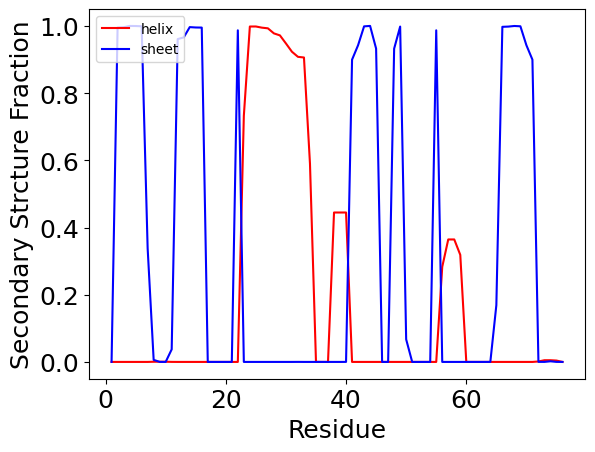

In [15]:
dssp=md.compute_dssp(trj,simplified=True)

def dssp_convert(dssp):
 dsspH=np.copy(dssp)
 dsspE=np.copy(dssp)
 dsspH[dsspH=='H']=1                                                                                      
 dsspH[dsspH=='E']=0                                                                                      
 dsspH[dsspH=='C']=0                                                                                      
 dsspH[dsspH=='NA']=0 
 dsspH=dsspH.astype(int)
 TotalH=np.sum(dsspH,axis=1) 
 Hprop=np.sum(dsspH,axis=0).astype(float)/len(dsspE) 

 dsspE[dsspE=='H']=0
 dsspE[dsspE=='E']=1
 dsspE[dsspE=='C']=0
 dsspE[dsspE=='NA']=0
 dsspE=dsspE.astype(int)
 TotalE=np.sum(dsspE,axis=1) 
 Eprop=np.sum(dsspE,axis=0).astype(float)/len(dsspE) 
 return Hprop, Eprop

Hprop,Eprop=dssp_convert(dssp)
plt.plot(residue_num,Hprop,c='r',label='helix')
plt.plot(residue_num,Eprop,c='b',label='sheet')

plt.legend(loc="upper left")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=18)


SS: H [24 25 26 27 28 29 30 31 32 33]
SS: E [ 2  3  4  5  6 12 13 14 15 16 42 43 44 45 48 49 66 67 68 69 70]
SS: I []
SS: G []
SS: B [22 55]
SS: T [19 20 46 47 52 53 60 63 64]
SS: S []
SS:   [ 1 11 17 18 35 36 37 50 51 61 62 72 76]


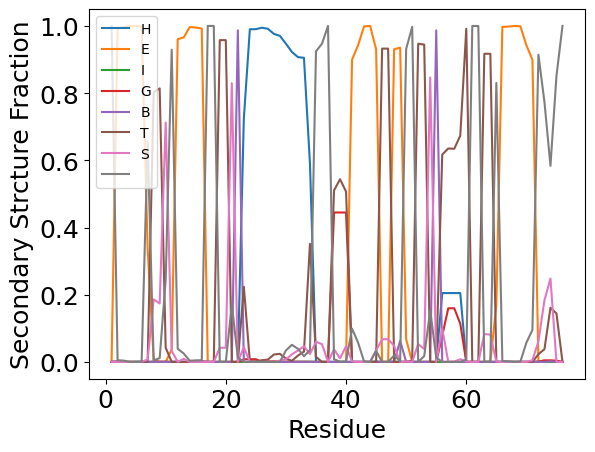

In [16]:
dssp_full=md.compute_dssp(trj,simplified=False)

def dssp_convert_type(dssp,type):
 dsspS=np.copy(dssp)
 dsspS[dsspS!=type]=0                                                                                      
 dsspS[dsspS==type]=1   # you could do this with an if as well                                                                                   
 dsspS=dsspS.astype(int)
 TotalS=np.sum(dsspS,axis=1) 
 Sprop=np.sum(dsspS,axis=0).astype(float)/len(dsspS) 
 return Sprop

for t in ['H','E','I','G','B','T','S',' ']:
  Tprop=dssp_convert_type(dssp_full,t)
  plt.plot(residue_num,Tprop,label=t)
  print("SS:",t,np.asarray(residue_num)[np.where(Tprop>.90)])

plt.legend(loc="upper left")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=18)


In [17]:
#Find all the frames where a given residue is H or E
# you can repurpose this for picking out phi psi angles in energy wells as well
residue_number=39
array_index=residue_number-0
print(np.asarray(residue_num)[array_index])
helix_frames=np.where(dssp[:,array_index]=='H')[0]
beta_frames=np.where(dssp[:,array_index]=='E')[0]

print("Residue %s"%np.asarray(residue_num)[array_index])
print("helix frames:",len(helix_frames),helix_frames)
print("beta frames:",len(beta_frames),beta_frames)

40
Residue 40
helix frames: 4486 [    2     3     4 ... 10085 10086 10087]
beta frames: 1 [4609]


In [18]:
indices_phi, phis = md.compute_phi(trj)
indices_psi, psis = md.compute_psi(trj)
indices_chi1, chi1s = md.compute_chi1(trj)
indices_chi2, chi2s = md.compute_chi2(trj)

In [19]:
phi_dict={}
dihedral_dict = { 'phi': { },
          'psi': { },
          'chi1': { },
          'chi2': { }}

for i in range(0,len(indices_phi)):
  indices=indices_phi[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['phi'][resnum]=phis[:,i]

for i in range(0,len(indices_psi)):
  indices=indices_psi[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['psi'][resnum]=psis[:,i]

for i in range(0,len(indices_chi1)):
  indices=indices_chi1[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['chi1'][resnum]=chi1s[:,i]

for i in range(0,len(indices_chi2)):
  indices=indices_chi2[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['chi2'][resnum]=chi2s[:,i]

In [20]:
sequence

' [MET1, GLN2, ILE3, PHE4, VAL5, LYS6, THR7, LEU8, THR9, GLY10, LYS11, THR12, ILE13, THR14, LEU15, GLU16, VAL17, GLU18, PRO19, SER20, ASP21, THR22, ILE23, GLU24, ASN25, VAL26, LYS27, ALA28, LYS29, ILE30, GLN31, ASP32, LYS33, GLU34, GLY35, ILE36, PRO37, PRO38, ASP39, GLN40, GLN41, ARG42, LEU43, ILE44, PHE45, ALA46, GLY47, LYS48, GLN49, LEU50, GLU51, ASP52, GLY53, ARG54, THR55, LEU56, SER57, ASP58, TYR59, ASN60, ILE61, GLN62, LYS63, GLU64, SER65, THR66, LEU67, HIS68, LEU69, VAL70, LEU71, ARG72, LEU73, ARG74, GLY75, GLY76]'

In [21]:
#Heres a function to plot a phi/psi ramachandran plot:

def plot_phipsi(res):
 plt.hist2d(dihedral_dict['phi'][res],dihedral_dict['psi'][res],bins=36,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
 plt.xlabel('$\phi$', size=18)
 plt.ylabel('$\psi$', size=18)
 plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.tick_params(labelsize=18)
 plt.show()
 return

def plot_chi(res):
    if res in dihedral_dict['chi1']:
     plt.hist(dihedral_dict['chi1'][res],bins=36,range=[-3.14,3.14])        
     plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.xlabel('$\chi_1$', size=18)
     plt.ylabel('counts', size=18)
     plt.tick_params(labelsize=18)
     plt.show()
     plt.clf()   
    if res in dihedral_dict['chi2']:
     plt.hist2d(dihedral_dict['chi1'][res],dihedral_dict['chi2'][res],bins=36,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
     plt.xlabel('$\chi_1$', size=18)
     plt.ylabel('$\chi_2$', size=18)
     plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.tick_params(labelsize=18)
     plt.show()
    return




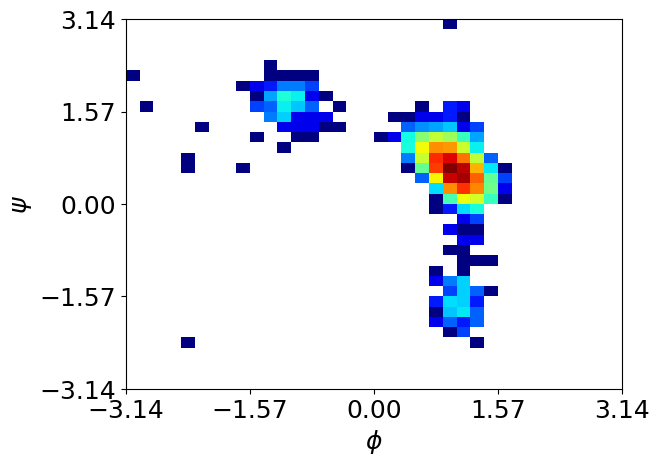

In [22]:
plot_phipsi(46)

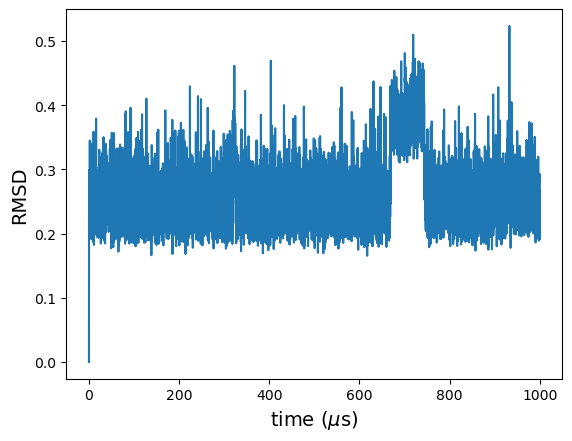

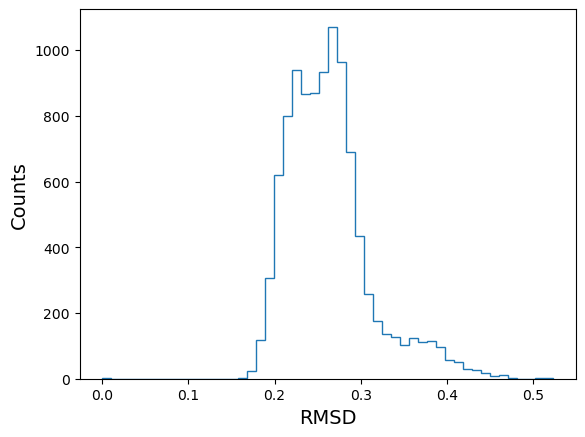

In [23]:
#Lets Calculate the RMSD and make a histogram from the starting structure 
#predict backbone within 2A so that sidechains will be in the right rotomers for alphafold
#RMSD will explore higher variations then come back
# This isn't that informative, but can clue you in on states
time=np.linspace(0,1000,trj.n_frames)
rmsd = md.rmsd(trj, trj, 0)
plt.plot(time,rmsd)
plt.ylabel('RMSD',size=14);
plt.xlabel('time ($\mu$s)',size=14)
plt.show()
plt.clf()

plt.hist(rmsd,histtype='step',bins=50)
plt.ylabel('Counts',size=14);
plt.xlabel('RMSD',size=14)
plt.show()

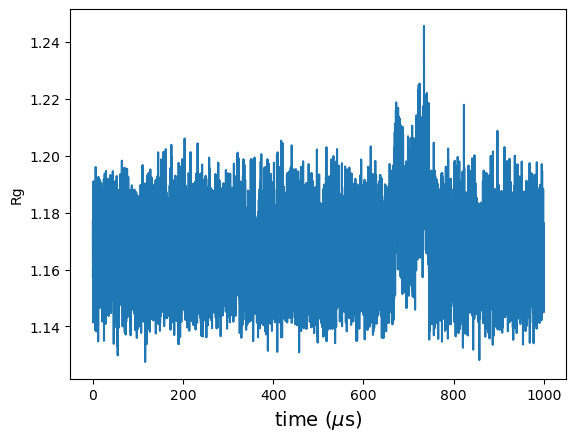

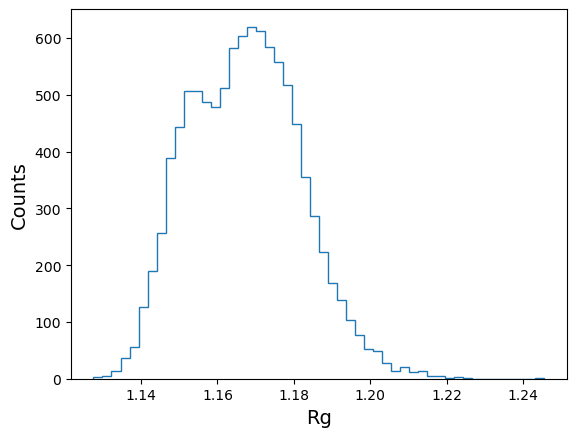

In [24]:
#Lets calculate the radius of gyration and make a histogram
#calc center of mass, you can tell it MW for each atoms if you would like, look at how compact or extended it is
rg=md.compute_rg(trj, masses=None) #just pick Calphas like this does, 
plt.plot(time,rg)
plt.ylabel('Rg');
plt.xlabel('time ($\mu$s)',size=14)
plt.show()
plt.clf()

plt.hist(rg,histtype='step',bins=50)
plt.ylabel('Counts',size=14);
plt.xlabel('Rg',size=14)
plt.show()

In [25]:
#Lets identify subtantially populated hydrogen bonds
hbonds = md.baker_hubbard(trj, periodic=False)
label = lambda hbond : '%s -- %s' % (trj.topology.atom(hbond[0]), trj.topology.atom(hbond[2]))
for hbond in hbonds:
    print(label(hbond))
#donor on left, acceptor on the right, looks at angles to see if acceptable H bond is available there

MET1-N -- VAL17-O
MET1-N -- VAL17-O
MET1-N -- VAL17-O
ILE3-N -- LEU15-O
PHE4-N -- SER65-O
VAL5-N -- ILE13-O
LYS6-N -- LEU67-O
THR7-N -- LYS11-O
LEU8-N -- THR7-OG1
LEU8-N -- LEU69-O
THR9-N -- THR7-OG1
GLY10-N -- THR7-O
LYS11-N -- THR7-OG1
LYS11-NZ -- GLU34-OE1
LYS11-NZ -- GLU34-OE2
LYS11-NZ -- GLU34-OE1
LYS11-NZ -- GLU34-OE2
LYS11-NZ -- GLU34-OE1
LYS11-NZ -- GLU34-OE2
ILE13-N -- VAL5-O
LEU15-N -- ILE3-O
VAL17-N -- MET1-O
GLU18-N -- ASP21-OD1
GLU18-N -- ASP21-OD2
ASP21-N -- GLU18-O
THR22-N -- ASN25-OD1
ILE23-N -- ARG54-O
GLU24-N -- ASP52-O
ASN25-N -- THR22-OG1
ASN25-N -- THR22-O
ASN25-ND2 -- THR22-OG1
ASN25-ND2 -- THR22-OG1
VAL26-N -- THR22-O
VAL26-N -- ILE23-O
LYS27-N -- ILE23-O
LYS27-NZ -- GLN41-O
LYS27-NZ -- ASP52-OD1
LYS27-NZ -- ASP52-OD2
LYS27-NZ -- GLN41-O
LYS27-NZ -- ASP52-OD1
LYS27-NZ -- ASP52-OD2
LYS27-NZ -- GLN41-O
LYS27-NZ -- ASP52-OD1
LYS27-NZ -- ASP52-OD2
ALA28-N -- GLU24-O
LYS29-N -- ASN25-O
LYS29-N -- VAL26-O
ILE30-N -- VAL26-O
ILE30-N -- LYS27-O
GLN31-N -- LYS27-O
ASP32-N

In [26]:
for hbond in hbonds:
 donor = top.atom(hbond[0])
 acc = top.atom(hbond[2])
 print(hbond,donor,acc)

[  0   1 285] MET1-N VAL17-O
[  0   2 285] MET1-N VAL17-O
[  0   3 285] MET1-N VAL17-O
[ 36  37 254] ILE3-N LEU15-O
[  55   56 1044] PHE4-N SER65-O
[ 75  76 221] VAL5-N ILE13-O
[  91   92 1077] LYS6-N LEU67-O
[113 114 188] THR7-N LYS11-O
[127 128 119] LEU8-N THR7-OG1
[ 127  128 1113] LEU8-N LEU69-O
[146 147 119] THR9-N THR7-OG1
[160 161 126] GLY10-N THR7-O
[167 168 119] LYS11-N THR7-OG1
[183 184 551] LYS11-NZ GLU34-OE1
[183 184 552] LYS11-NZ GLU34-OE2
[183 185 551] LYS11-NZ GLU34-OE1
[183 185 552] LYS11-NZ GLU34-OE2
[183 186 551] LYS11-NZ GLU34-OE1
[183 186 552] LYS11-NZ GLU34-OE2
[203 204  90] ILE13-N VAL5-O
[236 237  54] LEU15-N ILE3-O
[270 271  18] VAL17-N MET1-O
[286 287 334] GLU18-N ASP21-OD1
[286 287 335] GLU18-N ASP21-OD2
[326 327 300] ASP21-N GLU18-O
[338 339 394] THR22-N ASN25-OD1
[352 353 869] ILE23-N ARG54-O
[371 372 838] GLU24-N ASP52-O
[386 387 344] ASN25-N THR22-OG1
[386 387 351] ASN25-N THR22-O
[395 396 344] ASN25-ND2 THR22-OG1
[395 397 344] ASN25-ND2 THR22-OG1
[400 401 

[992 994 960] GLN62-NE2 ASN60-O


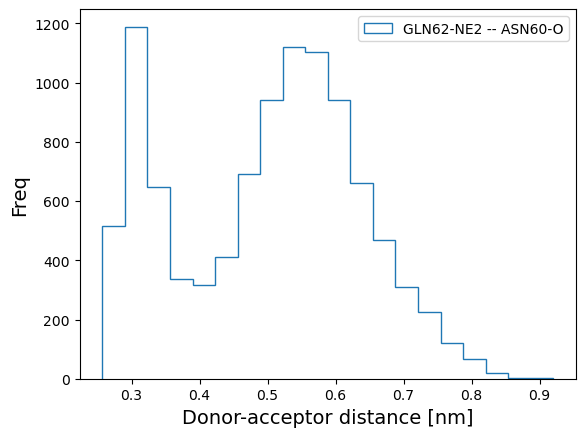

In [27]:
# looks at 4th Hbond and calculates the H-bond distances
Hbond_index=94 #change to something more exciting
hbond=hbonds[Hbond_index]
donor = top.atom(hbond[0])
acc = top.atom(hbond[2])
print(hbond,donor,acc)

da_distance = md.compute_distances(trj, [[hbond[0],hbond[2]]], periodic=False)
plt.plot(da_distance)
plt.show
plt.clf()

plt.hist(da_distance,histtype='step',bins=20, label=label(hbonds[Hbond_index]))
#for i in [2, 3, 4]:
#    plt.hist(da_distances[:, i], color=next(color),histtype='step',bins=10, label=label(hbonds[i]), alpha=0.5)
plt.legend()
plt.ylabel('Freq',size=14);
plt.xlabel('Donor-acceptor distance [nm]',size=14)
plt.show()

***We're going to run a Principle Component Analysis (PCA)***

This takes the variance of the cartesian coordinates of each atom over the course of the trajectory and finds "projections" that explain as much of variance as posisble.

https://en.wikipedia.org/wiki/Principal_component_analysis

In [28]:
import sklearn
from sklearn.decomposition import PCA

pca1 = PCA(n_components=2)
trj.superpose(trj, 0)
reduced_cartesian = pca1.fit_transform(trj.xyz.reshape(trj.n_frames, trj.n_atoms * 3)) #this is done because this has lots of dimensions
print(reduced_cartesian.shape) #look at as a function of time, and project onto first 2 components
# makes co-variance matrix, looking at how much the positions of atoms are coorelated across the residues
# look into linear algebra eigen values and vectors....

(10088, 2)


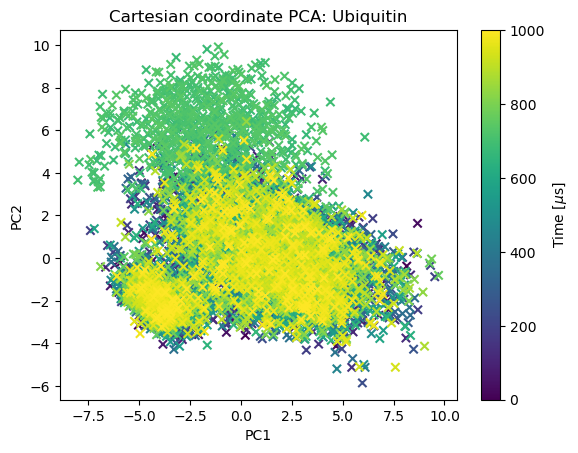

In [33]:
#We Can plot eaceh frame as a function of the values of each PC(principal component): PC1 and PC2
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=time)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: Ubiquitin')
cbar = plt.colorbar()
cbar.set_label('Time [$\mu$s]')
#when you reduce dimensionality for PCA, you want to project properties back onto there to make sure that you have captured relevant information

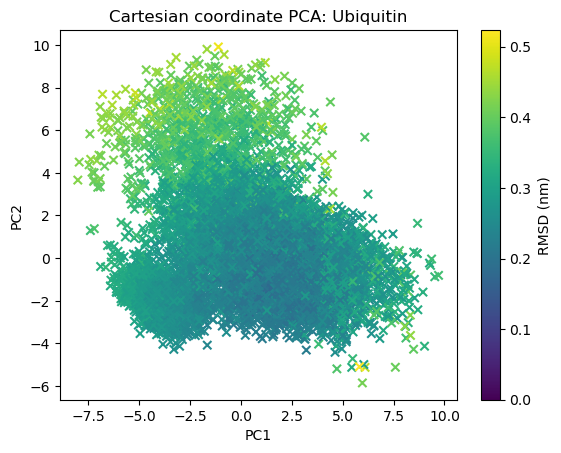

In [34]:
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=rmsd)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: Ubiquitin')
cbar = plt.colorbar()
cbar.set_label('RMSD (nm)')

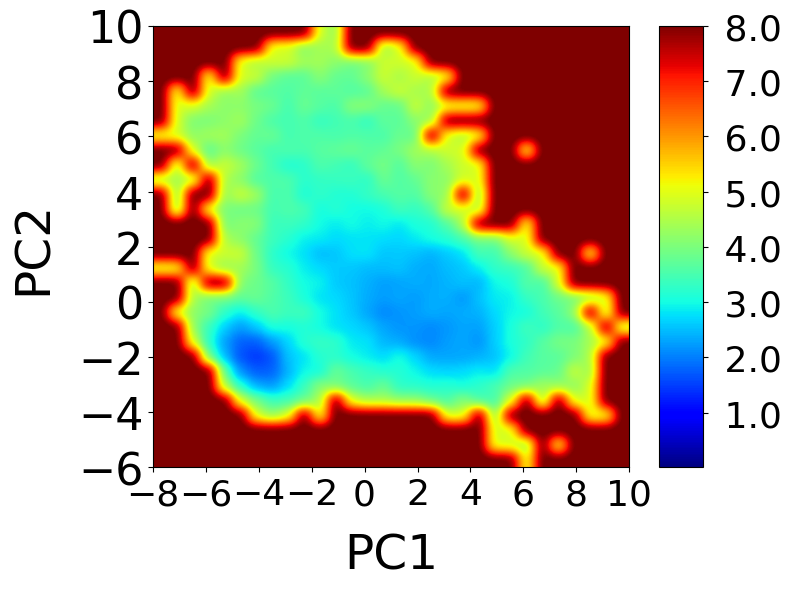

In [35]:
###Lets Make a Pretty Free Energy Plot of PC1 vs. PC2

def free_energy(a, b, T, y0, ymax, x0, xmax):
    free_energy, xedges, yedges = np.histogram2d(
        a, b, 30, [[y0, ymax], [x0, xmax]], density=True, weights=None)
    free_energy = np.log(np.flipud(free_energy)+.000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xedges, yedges

PC1=reduced_cartesian[:, 0]
PC2=reduced_cartesian[:,1]

dG,xedges,yedges=free_energy(PC2, PC1, 300, -6, 10, -8, 10)

fig = plt.figure(figsize=(8, 6))
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3, 4, 5,6,7,8]
plt.xlim(-8,10)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("PC2", size=35, labelpad=15)
plt.xlabel("PC1", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=8.0)
plt.yticks(size='26')
plt.tight_layout()

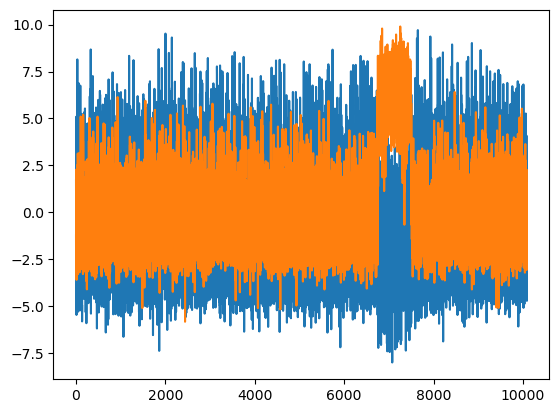

In [36]:
plt.plot(PC1)
plt.plot(PC2)
# PC2 shows the most change 

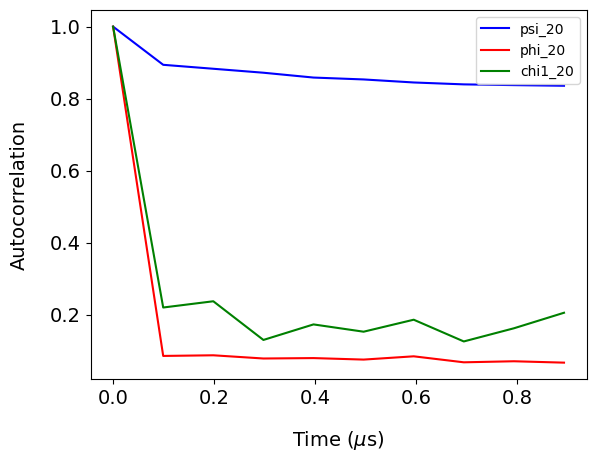

In [37]:
#Lets Calculate Some Correlation Times of Some Dihedral angles.
def autocorr1(x,lags):
    '''numpy.corrcoef, partial'''
    corr=[1. if l==0 else np.corrcoef(x[l:],x[:-l])[0][1] for l in lags]
    return np.array(corr)

#time in microseconds
time=np.linspace(0,1000,trj.n_frames)


lags=range(10) #takes time series, and coorelates it to itself but lagged by 10 steps
#C1C2bondlength[:,0]
phi2_acf=autocorr1(dihedral_dict['psi'][30],lags)
phi20_acf=autocorr1(dihedral_dict['phi'][30],lags)
chi20_acf=autocorr1(dihedral_dict['chi1'][30],lags)

plt.plot(time[lags],phi2_acf,color='b',label='psi_20')
plt.plot(time[lags],phi20_acf,color='r',label='phi_20')
plt.plot(time[lags],chi20_acf,color='g',label='chi1_20')

plt.legend()
plt.xlabel("Time ($\mu$s)", size=14, labelpad=15)
plt.ylabel("Autocorrelation", size=14, labelpad=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(size='14')
plt.yticks(size='14')
plt.show()

In [30]:
#Lets Make a Contact Map
contact_maps = []
contact_distances = []
for i in range(1, 76):
    contact_map = []
    contact_distance = []
    for j in range(1, 76):
        if i == j:
            contacts = 0
        else:
            dist = md.compute_contacts(trj, [[i, j]])
            array = np.asarray(dist[0]).astype(float)
            distance = np.average(array)
            contact_distance.append(distance)
            contact = np.where(array < 0.5, 1, 0)
            contacts = np.average(contact)
        contact_map.append(contacts)
    contact_maps.append(contact_map)
    contact_distances.append(contact_distance)
final_map = np.asarray(contact_maps).astype(float)
final_distance = np.asarray(contact_distances).astype(float)


KeyboardInterrupt: 

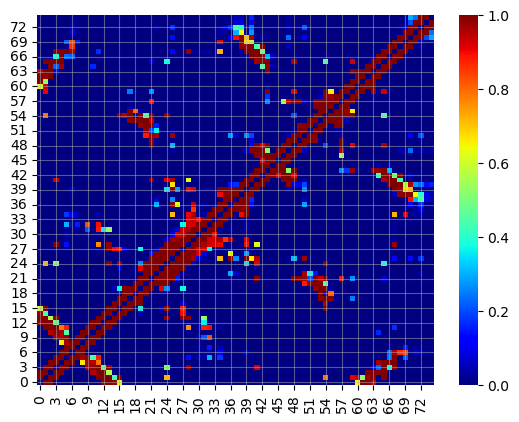

In [54]:
ax = sns.heatmap(final_map, vmin=0.0, vmax=1.0,cmap='jet')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)

In [36]:
res_num

' [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76]'

Lets think about some fun things we can do with this trajectory.  

Rubric (Completing the bolded tasks and attempting some additional tasks puts an assignment in the ~"P - B/B+" range, attempting and completing some additional more advanced tasks will earn a ~"HP - A/A-").  Very parital or incomplete attempts for the bolded questiosn is in the ~"LP / B-/C+"

Ideas: #Each of these need a few sentences to answer!!!!!

**1.) Determine what is structural different about the "minor state" populated between 650-750us.  Can you make a visualization of the two states?** 

**2.)  Identify some dihedral angles that have very long correlation times? Can you your provide structural snapshots that explain why certain correlation times are longer?**

  More Advanced:
  
  2a) Can you calculate/ fit the correlation times? 
  
  2b) Can you write a loop to scan over all phi/psi/chi1/chi2 residues and identify residues with correlation times longer than a given threshold? 
--use dictionaries and figure out what these interactions are 

3)Considering the minor state, can you find residues that have large changes in the distributions of backbone or sidechain dihedral angles?  Are there torsion angles with large differences in their correlation times between states?  Can you provide trajectory snapshots that explain why?

**4) Calculate the ciruclar correlation coefficients between phi and psi angles and reproduce the correlation map from below**  -Look into using a "mask" to eliminate some entries in the correlation matrix and make your plot prettier. 

5) Make a 2D map showing the populations of hydrogen bonds between different residues.

6) Compare the contact maps, dihedral correlations, and hydrogen bond populations between the major and minor states.

7) Compare the contact maps, dihedral correlations, and hydrogen bond populations for different subsets of PC space (ie PC1 is on the intevral [lower1,upper1] and PC2 is on the invertval [lower2,upper2]

7) Compute an visualize all-to-all RMSD calculation of the frames of this trajectory.  

8) Cluster the conformations of the trajectory in some way.  Perhaps consider using the all-to-all rmsd distances, or the the values of PCs.  (Consult https://mdtraj.org/1.9.4/examples/clustering.html or https://mdtraj.org/1.9.4/examples/centroids.html for examples)

9) Visualize the most populated clusters from your clustering analysis

**1.) Determine what is structural different about the "minor state" populated between 650-750us.  Can you make a visualization of the two states?**

In [31]:
np.argmax(rg)

7408

In [38]:
major_state_indices = np.where((PC2 < 2) & (PC2 > -2))[0]  
minor_state_indices = np.where((PC2 < 10) & (PC2 > 5))[0]  

major_state_selected = major_state_indices[::20]

print(major_state_selected)
print(minor_state_indices)

[    0    26    54    81   108   136   164   189   222   255   279   310
   345   379   412   438   468   493   522   547   577   605   634   658
   690   719   750   778   806   831   856   882   918   946   973  1004
  1035  1061  1085  1111  1133  1164  1191  1219  1247  1276  1309  1331
  1361  1392  1417  1444  1473  1502  1525  1558  1582  1618  1650  1681
  1705  1735  1767  1797  1819  1850  1877  1903  1941  1969  2000  2029
  2055  2080  2109  2141  2171  2194  2218  2252  2286  2314  2343  2371
  2400  2431  2455  2488  2525  2554  2581  2615  2644  2674  2697  2719
  2747  2776  2801  2827  2854  2882  2919  2941  2968  2996  3026  3052
  3080  3107  3138  3163  3195  3221  3264  3286  3318  3345  3373  3403
  3434  3460  3486  3513  3544  3573  3601  3629  3662  3692  3725  3753
  3781  3812  3844  3877  3915  3945  3974  3999  4028  4054  4089  4116
  4155  4185  4216  4239  4271  4302  4330  4356  4386  4409  4444  4470
  4495  4520  4550  4579  4610  4650  4677  4711  4

 Below, frame 7408 was pulled to represent the minor state (opaque) while frame 222 represents the major state (transparent.) When analyzing the minor state, there are some obvious changes in secondary structure highlighted below. Noteably, a loop flips inward, participating in electrostatic interactions with the alpha helix backbone, and destabilizing the alpha helix in purple. This causes the neighboring 3-5 helix (blue) to shift in position. Additionally, this flipped loop results in a bending of the neighboring beta strand, causing four beta strands in the sheet to shift outward. Overall, the minor state is visibly less compact  which is also indicated by a larger Rg and RMSD.

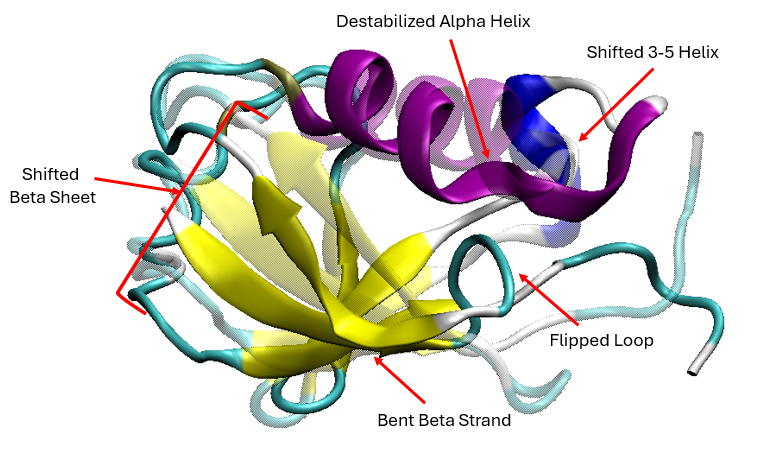

**2.)  Identify some dihedral angles that have very long correlation times? Can you your provide structural snapshots that explain why certain correlation times are longer?**


In [39]:
sequence

' [MET1, GLN2, ILE3, PHE4, VAL5, LYS6, THR7, LEU8, THR9, GLY10, LYS11, THR12, ILE13, THR14, LEU15, GLU16, VAL17, GLU18, PRO19, SER20, ASP21, THR22, ILE23, GLU24, ASN25, VAL26, LYS27, ALA28, LYS29, ILE30, GLN31, ASP32, LYS33, GLU34, GLY35, ILE36, PRO37, PRO38, ASP39, GLN40, GLN41, ARG42, LEU43, ILE44, PHE45, ALA46, GLY47, LYS48, GLN49, LEU50, GLU51, ASP52, GLY53, ARG54, THR55, LEU56, SER57, ASP58, TYR59, ASN60, ILE61, GLN62, LYS63, GLU64, SER65, THR66, LEU67, HIS68, LEU69, VAL70, LEU71, ARG72, LEU73, ARG74, GLY75, GLY76]'

In [40]:
residue_of_interest = [8, 9, 10, 11, 12, 13, 14, 30, 31, 32, 33, 34]
indice_calculator = [residue - 1 for residue in residue_of_interest]
print(indice_calculator)

[7, 8, 9, 10, 11, 12, 13, 29, 30, 31, 32, 33]


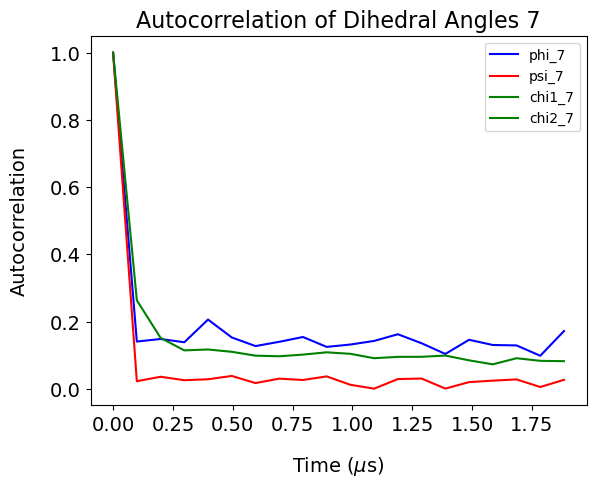

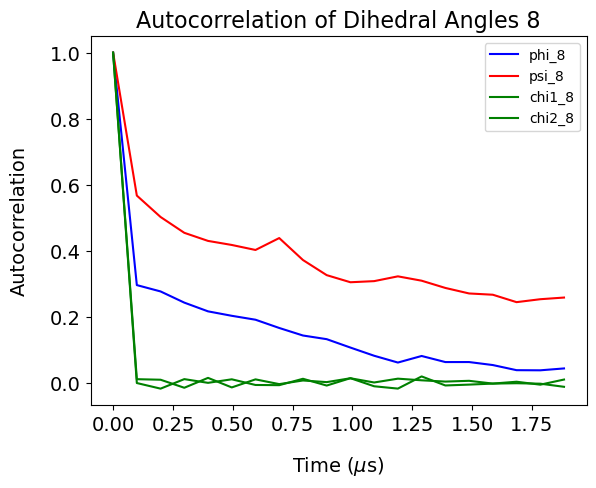

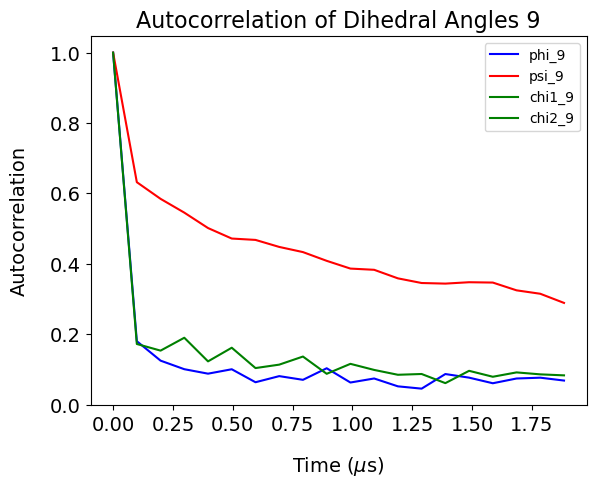

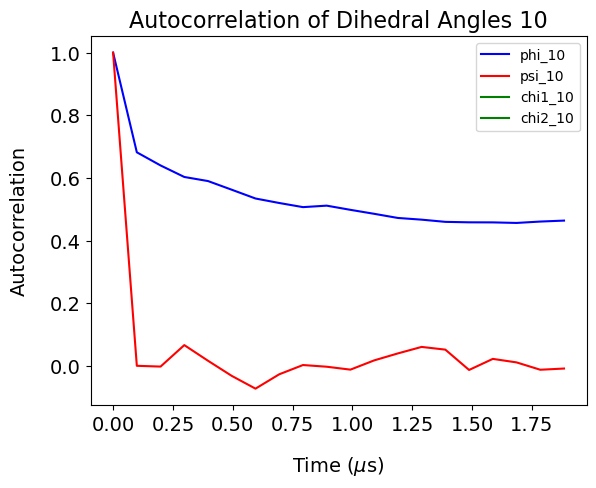

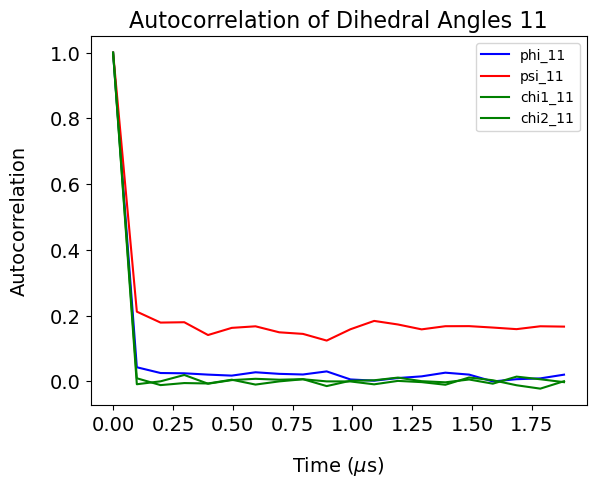

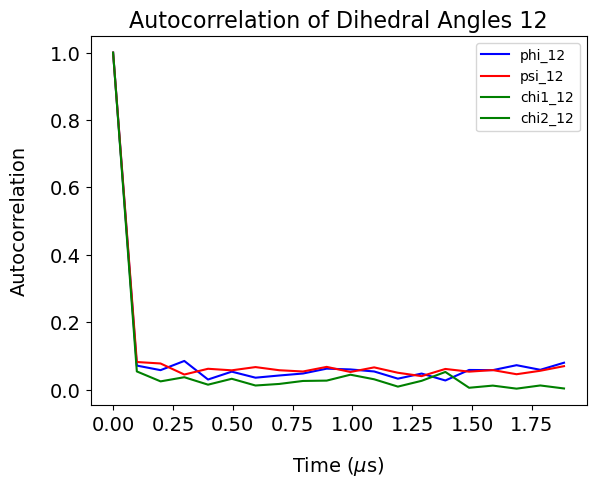

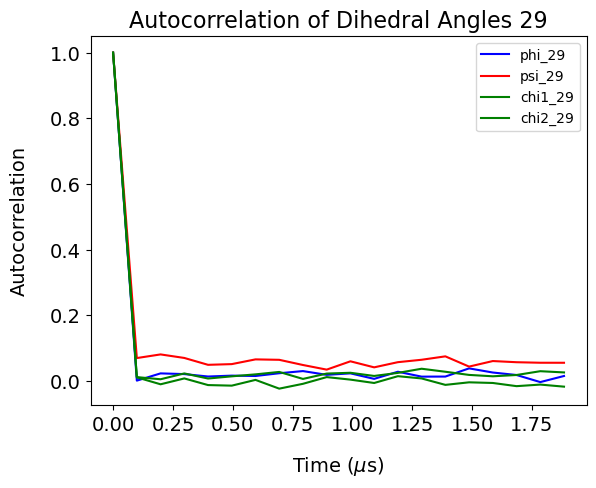

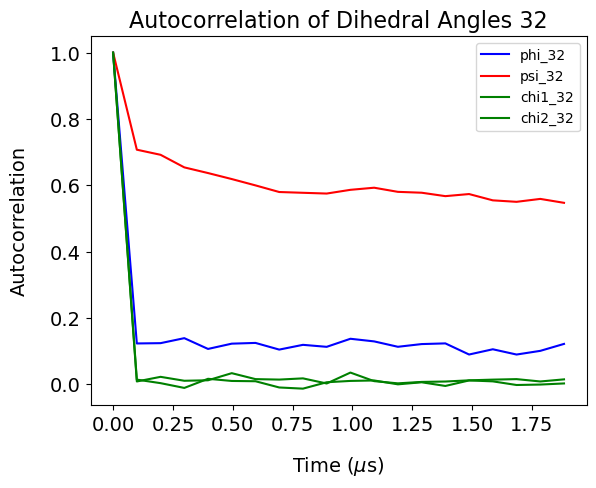

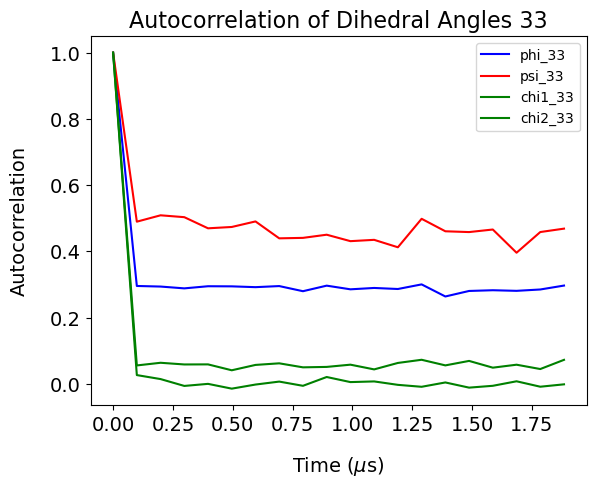

In [86]:
#After analyzing the protein structure in VMD, I decided to check the auto correlation times of residues in regions that display great structural changes in the minor state. 
#I made a list of residues in the flipped loop region, the bent beta sheet region, and the destabilized alpha helix region. 
import matplotlib.pyplot as plt
import numpy as np

def autocorr1(x, lags):
    '''numpy.corrcoef, partial'''
    corr = [1. if l == 0 else np.corrcoef(x[l:], x[:-l])[0][1] for l in lags]
    return np.array(corr)

#residue_of_interest = 8, 9, 10, 11, 12, 13, 14, 30, 31, 32, 33, 34
residue_indices = [7, 8, 9, 10, 11, 12, 13, 29, 30, 31, 32, 33]
# Define time in microseconds
time = np.linspace(0, 1000, trj.n_frames)
lags = range(20)  # Takes time series and correlates it to itself but lagged by 10 steps

# Iterate over each residue in array
for res in residue_indices:
    # Calculate autocorrelation for phi, psi, chi1, and chi2 for the current residue
    phi_acf = autocorr1(dihedral_dict['phi'].get(res, []), lags)
    psi_acf = autocorr1(dihedral_dict['psi'].get(res, []), lags)
    chi1_acf = autocorr1(dihedral_dict.get('chi1', {}).get(res, []), lags)
    chi2_acf = autocorr1(dihedral_dict.get('chi2', {}).get(res, []), lags)

    # Plot autocorrelation for each dihedral angle
    plt.plot(time[lags], phi_acf, color='b', label=f'phi_{res}')
    plt.plot(time[lags], psi_acf, color='r', label=f'psi_{res}')
    plt.plot(time[lags], chi1_acf, color='g', label=f'chi1_{res}')
    plt.plot(time[lags], chi2_acf, color='g', label=f'chi2_{res}')

    plt.xlabel("Time ($\mu$s)", size=14, labelpad=15)
    plt.ylabel("Autocorrelation", size=14, labelpad=15)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xticks(size='14')
    plt.yticks(size='14')
    plt.title(f"Autocorrelation of Dihedral Angles {res}", size=16)
    plt.legend()
    plt.show()

#This will get angry when it encounters residues that don't have all of the dihedral residues, but thats okay. I will ignore this. 

2a) Can you calculate/ fit the correlation times? 

C:\Users\grace\AppData\Local\Temp\ipykernel_12316\3322245895.py:32: OptimizeWarning: Covariance of the parameters could not be estimated
  linfit_angle, _ = curve_fit(linear_func, time[lags[:2]], angle_acf[:2])


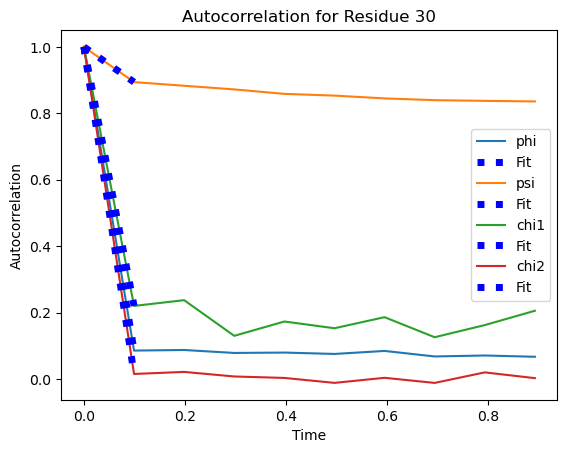

In [99]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define autocorrelation function
def autocorr1(x, lags):
    '''numpy.corrcoef, partial'''
    corr = [1. if l == 0 else np.corrcoef(x[l:], x[:-l])[0][1] for l in lags]
    return np.array(corr)

# Generate time values
time = np.linspace(0, 1000, trj.n_frames)

# Define lags for autocorrelation analysis
lags = range(10)

index = 30

# Initialize the plot
plt.figure()

# Iterate over each angle (phi, psi, chi1, chi2)
for angle in ['phi', 'psi', 'chi1', 'chi2']:
    # Calculate autocorrelation for the chosen residue and angle
    angle_acf = autocorr1(dihedral_dict[angle].get(index, np.zeros(trj.n_frames)), lags)
    
    # Define a linear function for regression
    def linear_func(t, m, c):
        return m * t + c

    # Perform linear regression for the autocorrelation curve using the first two lag values
    linfit_angle, _ = curve_fit(linear_func, time[lags[:2]], angle_acf[:2])
    
    # Plot autocorrelation and linear regression function
    plt.plot(time[lags], angle_acf, label=f'{angle}')
    plt.plot(time[lags[:2]], linear_func(time[lags[:2]], *linfit_angle), color='b',label='Fit', linestyle=":", linewidth=5)

plt.xlabel('Time')
plt.ylabel('Autocorrelation')
plt.title(f'Autocorrelation for Residue {index}')
plt.legend()
plt.show()
#This will be angry, but thats okay! It's explaining that the fit is not very good for all the data, but that is because I am intentially only using the first two lag times. 
#In doing this, I can get the slope of the line, and pull out the tau values. 

2b) Can you write a loop to scan over all phi/psi/chi1/chi2 residues and identify residues with correlation times longer than a given threshold? 
--use dictionaries and figure out what these interactions are 

In [72]:
#First, I will need to adapt my code to pull out the linear fit slopes, use this to calc autocorrelation times and store them. 
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define autocorrelation function
def autocorr1(x, lags):
    '''numpy.corrcoef, partial'''
    corr = [1. if l == 0 else np.corrcoef(x[l:], x[:-l])[0][1] for l in lags]
    return np.array(corr)

# Generate time values
time = np.linspace(0, 1000, trj.n_frames)

# Define lags for autocorrelation analysis
lags = range(10)

auto_corr_time_dict = {}
# Iterate over each residue in residues array
for angle in dihedral_dict.keys():
    for residue in dihedral_dict[angle].keys():
        # Calculate autocorrelation for each dihedral angle
        angle_acf = autocorr1(dihedral_dict[angle].get(residue, np.zeros(trj.n_frames)), lags)
    
        # Define a linear function for regression
        def linear_func(t, m, c):
            return m * t + c

        # Perform linear regression for each autocorrelation curve using the first two lag values
        linfit_angle, _ = curve_fit(linear_func, time[lags[:2]], angle_acf[:2])

        # Print the slopes
        print(f"Autocorrelation time for {angle} at residues {residue}: {-1/linfit_angle[0]}")
        if angle not in auto_corr_time_dict.keys(): \
            auto_corr_time_dict[angle]={}
        auto_corr_time_dict[angle][residue] = - 1/linfit_angle[0]
        

C:\Users\grace\AppData\Local\Temp\ipykernel_12316\3873399171.py:30: OptimizeWarning: Covariance of the parameters could not be estimated
  linfit_angle, _ = curve_fit(linear_func, time[lags[:2]], angle_acf[:2])


Autocorrelation time for phi at residues 2: 0.10237117413571663
Autocorrelation time for phi at residues 3: 0.10112463384307141
Autocorrelation time for phi at residues 4: 0.09890450409820384
Autocorrelation time for phi at residues 5: 0.10009596068619458
Autocorrelation time for phi at residues 6: 0.10822796295996352
Autocorrelation time for phi at residues 7: 0.11539688494939974
Autocorrelation time for phi at residues 8: 0.14095443156237034
Autocorrelation time for phi at residues 9: 0.1209723012029421
Autocorrelation time for phi at residues 10: 0.31167247140596144
Autocorrelation time for phi at residues 11: 0.10359177458368737
Autocorrelation time for phi at residues 12: 0.10678801210622141
Autocorrelation time for phi at residues 13: 0.10182745094188694
Autocorrelation time for phi at residues 14: 0.10704505968590512
Autocorrelation time for phi at residues 15: 0.10035688530476536
Autocorrelation time for phi at residues 16: 0.10011332634628946
Autocorrelation time for phi at re

In [76]:
auto_corr_time_dict.keys()

dict_keys(['phi', 'psi', 'chi1', 'chi2'])

In [78]:
auto_corr_time_dict["phi"].keys()

dict_keys([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76])

C:\Users\grace\AppData\Local\Temp\ipykernel_12316\4141338263.py:16: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_, pcov_ = curve_fit(linear_func, time[lags][:2], np.log(dihedral_acf[:2]))


Residue phi_10 has correlation time longer than 0.2 microseconds: 0.2589485499369226 microseconds.
Residue phi_35 has correlation time longer than 0.2 microseconds: 0.35628222049471764 microseconds.
Residue phi_60 has correlation time longer than 0.2 microseconds: 0.6571723722059817 microseconds.
Residue psi_9 has correlation time longer than 0.2 microseconds: 0.21613904017912391 microseconds.
Residue psi_13 has correlation time longer than 0.2 microseconds: 0.2631031176344731 microseconds.
Residue psi_30 has correlation time longer than 0.2 microseconds: 0.8851905604485097 microseconds.
Residue psi_31 has correlation time longer than 0.2 microseconds: 0.7952107223312426 microseconds.
Residue psi_32 has correlation time longer than 0.2 microseconds: 0.2862341826347261 microseconds.
Residue psi_34 has correlation time longer than 0.2 microseconds: 0.3363984268336095 microseconds.
Residue chi2_59 has correlation time longer than 0.2 microseconds: 0.6453330893171652 microseconds.


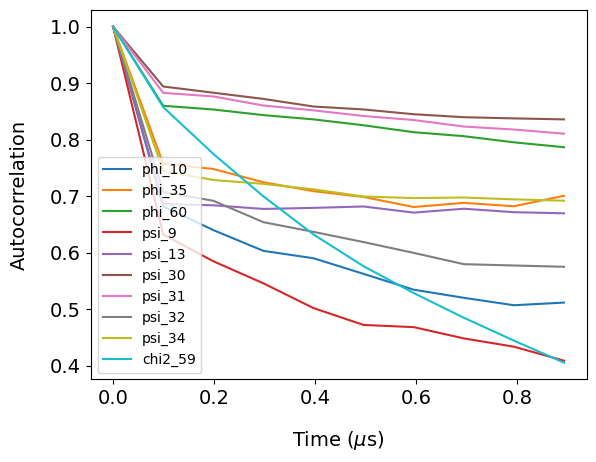

In [79]:
import numpy as np
import matplotlib.pyplot as plt
# Define your threshold value here (in microseconds)
threshold = 0.2

residues_above_threshold = []
# Loop over all phi/psi/chi1/chi2 residues
for residue_type in ['phi', 'psi', 'chi1', 'chi2']:
    for residue_number, dihedral_data in dihedral_dict[residue_type].items():
        # Calculate autocorrelation for each dihedral angle
        dihedral_acf = autocorr1(dihedral_data, lags)
        # Calculate correlation time (e.g., time for autocorrelation to decay to 0.1)
        correlation_time = 0
        if dihedral_acf[1] > 0:
            popt_, pcov_ = curve_fit(linear_func, time[lags][:2], np.log(dihedral_acf[:2]))
            correlation_time = -1/popt_[0]
            if correlation_time > threshold:
                residues_above_threshold.append((residue_type, residue_number, correlation_time))
                print(f"Residue {residue_type}_{residue_number} has correlation time longer than {threshold} microseconds: {correlation_time} microseconds.")
# Plotting only residues with correlation time greater than the threshold
for residue_type, residue_number, correlation_time in residues_above_threshold:
    dihedral_acf = autocorr1(dihedral_dict[residue_type][residue_number], lags)
    plt.plot(time[lags], dihedral_acf, label=f"{residue_type}_{residue_number}")
plt.legend()
plt.xlabel("Time ($\mu$s)", size=14, labelpad=15)
plt.ylabel("Autocorrelation", size=14, labelpad=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(size='14')
plt.yticks(size='14')
plt.show()

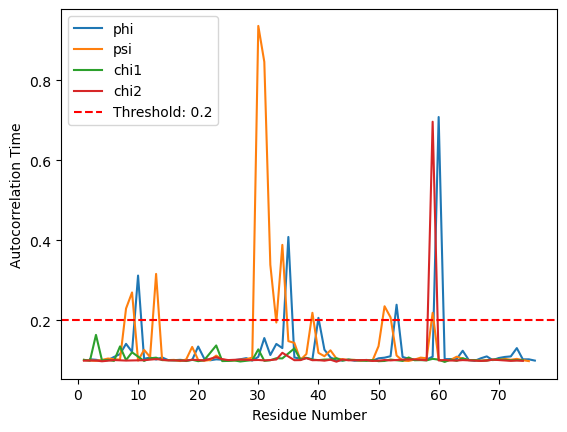

In [80]:
#This gives me a plot of the autocorrelation times for each dihedral angle for all residues. 
for angle in auto_corr_time_dict.keys(): 
    a_corr_arr = []
    residues = list(auto_corr_time_dict[angle].keys())
    for residue in residues:
        a_corr_arr.append(auto_corr_time_dict[angle][residue])
    plt.plot(residues, a_corr_arr, label=angle)
plt.legend()
plt.xlabel('Residue Number')  # Label for the x-axis
plt.ylabel('Autocorrelation Time')  # Label for the y-axis
plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold: {threshold}')  # Add a horizontal line for the threshold
plt.legend()
plt.show()

In [85]:
#Now I will do this again, but only looking at minor state frames

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define autocorrelation function
def autocorr2(x, lags):
    '''numpy.corrcoef, partial'''
    corr = [1. if l == 0 else np.corrcoef(x[l:], x[:-l])[0][1] for l in lags]
    return np.array(corr)

# Generate time values
time = np.linspace(0, 1000, trj.n_frames)

# Define lags for autocorrelation analysis
lags = range(10)

auto_corr_time_minor_dict = {}
# Iterate over each residue in residues array
for angle in dihedral_dict.keys():
    for residue in dihedral_dict[angle].keys():
        # Calculate autocorrelation for each dihedral angle
        angle_acf = autocorr1(dihedral_dict[angle].get(residue, np.zeros(trj.n_frames))[6500:7500], lags)
    
        # Define a linear function for regression
        def linear_func(t, m, c):
            return m * t + c

        # Perform linear regression for each autocorrelation curve using the first two lag values
        linfit_angle, _ = curve_fit(linear_func, time[lags[:2]], angle_acf[:2])

        # Print the slopes
        print(f"Autocorrelation time for {angle} at residues {residue} in the minor state: {-1/linfit_angle[0]}")
        if angle not in auto_corr_time_minor_dict.keys():
            auto_corr_time_minor_dict[angle] = {}
        auto_corr_time_minor_dict[angle][residue] = -1 / linfit_angle[0]

C:\Users\grace\AppData\Local\Temp\ipykernel_12316\1261424267.py:31: OptimizeWarning: Covariance of the parameters could not be estimated
  linfit_angle, _ = curve_fit(linear_func, time[lags[:2]], angle_acf[:2])


Autocorrelation time for phi at residues 2 in the minor state: 0.10291400201334505
Autocorrelation time for phi at residues 3 in the minor state: 0.09941214494765598
Autocorrelation time for phi at residues 4 in the minor state: 0.09616228225039372
Autocorrelation time for phi at residues 5 in the minor state: 0.10359187324120234
Autocorrelation time for phi at residues 6 in the minor state: 0.1388329927288422
Autocorrelation time for phi at residues 7 in the minor state: 0.12276803458858372
Autocorrelation time for phi at residues 8 in the minor state: 0.21816746793225958
Autocorrelation time for phi at residues 9 in the minor state: 0.14180644305730358
Autocorrelation time for phi at residues 10 in the minor state: 0.6516115065852919
Autocorrelation time for phi at residues 11 in the minor state: 0.10800969449773211
Autocorrelation time for phi at residues 12 in the minor state: 0.11886428136779026
Autocorrelation time for phi at residues 13 in the minor state: 0.11029877801985023
Au

C:\Users\grace\AppData\Local\Temp\ipykernel_12316\4103101994.py:15: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_, pcov_ = curve_fit(linear_func, time[lags][:2], np.log(dihedral_acf[:2]))


Residue phi_10 has correlation time longer than 0.2 microseconds: 0.2589485499369226 microseconds.
Residue phi_35 has correlation time longer than 0.2 microseconds: 0.35628222049471764 microseconds.
Residue phi_60 has correlation time longer than 0.2 microseconds: 0.6571723722059817 microseconds.
Residue psi_9 has correlation time longer than 0.2 microseconds: 0.21613904017912391 microseconds.
Residue psi_13 has correlation time longer than 0.2 microseconds: 0.2631031176344731 microseconds.
Residue psi_30 has correlation time longer than 0.2 microseconds: 0.8851905604485097 microseconds.
Residue psi_31 has correlation time longer than 0.2 microseconds: 0.7952107223312426 microseconds.
Residue psi_32 has correlation time longer than 0.2 microseconds: 0.2862341826347261 microseconds.
Residue psi_34 has correlation time longer than 0.2 microseconds: 0.3363984268336095 microseconds.
Residue chi2_59 has correlation time longer than 0.2 microseconds: 0.6453330893171652 microseconds.


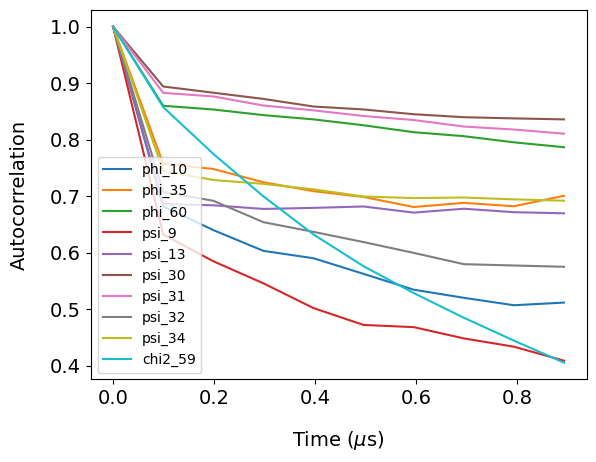

In [83]:

import numpy as np
import matplotlib.pyplot as plt
# Define your threshold value here (in microseconds)
threshold = 0.2

residues_above_threshold = []
# Loop over all phi/psi/chi1/chi2 residues
for residue_type in ['phi', 'psi', 'chi1', 'chi2']:
    for residue_number, dihedral_data in dihedral_dict[residue_type].items():
        # Calculate autocorrelation for each dihedral angle
        dihedral_acf = autocorr2(dihedral_data, lags)
        # Calculate correlation time (e.g., time for autocorrelation to decay to 0.1)
        correlation_time = 0
        if dihedral_acf[1] > 0:
            popt_, pcov_ = curve_fit(linear_func, time[lags][:2], np.log(dihedral_acf[:2]))
            correlation_time = -1/popt_[0]
            if correlation_time > threshold:
                residues_above_threshold.append((residue_type, residue_number, correlation_time))
                print(f"Residue {residue_type}_{residue_number} has correlation time longer than {threshold} microseconds: {correlation_time} microseconds.")
# Plotting only residues with correlation time greater than the threshold
for residue_type, residue_number, correlation_time in residues_above_threshold:
    dihedral_acf = autocorr2(dihedral_dict[residue_type][residue_number], lags)
    plt.plot(time[lags], dihedral_acf, label=f"{residue_type}_{residue_number}")
plt.legend()
plt.xlabel("Time ($\mu$s)", size=14, labelpad=15)
plt.ylabel("Autocorrelation", size=14, labelpad=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(size='14')
plt.yticks(size='14')
plt.show()

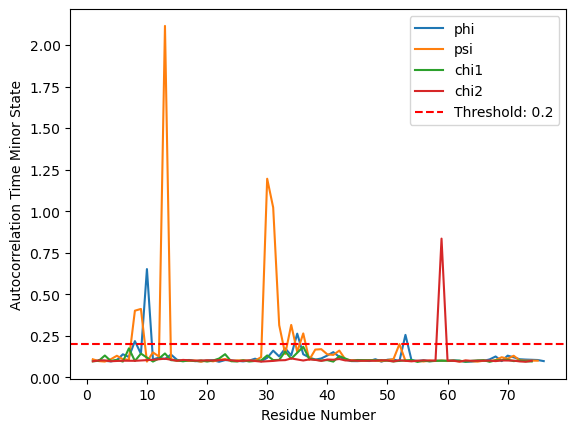

In [84]:
for angle in auto_corr_time_dict.keys(): 
    a_corr_arr = []
    residues = list(auto_corr_time_minor_dict[angle].keys())
    for residue in residues:
        a_corr_arr.append(auto_corr_time_minor_dict[angle][residue])
    plt.plot(residues, a_corr_arr, label=angle)
plt.legend()
plt.xlabel('Residue Number')  # Label for the x-axis
plt.ylabel('Autocorrelation Time Minor State')  # Label for the y-axis
plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold: {threshold}')  # Add a horizontal line for the threshold
plt.legend()
plt.show()

Below, I have shown all residues with strong autocorrelations in the major state (frame 222 transparent) and the minor state (frame 7408 opaque).  As you can see, all of these regions undergo changes in secondary structure element between the major and minor states. The destabilized end of the alpha helix shows great dynamic change for these residues in particle, and to demonstrate this dynamic portion of the helix containing residues 30 to 35 are shown below strided every 100 frames the minor state (purple). For visualization purposes, I have highlighted GLU 34 in cyan to demonstrate the greater degrees of freedom for this residue in particlar. 

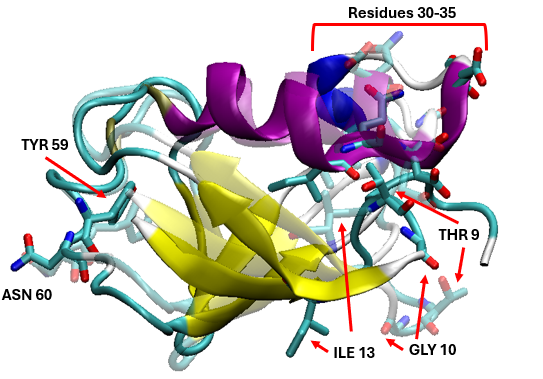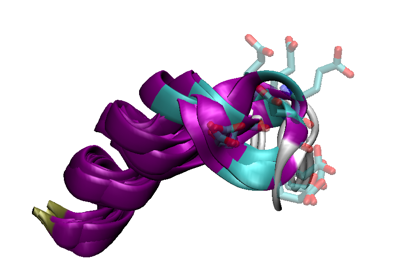

3)Considering the minor state, can you find residues that have large changes in the distributions of backbone or sidechain dihedral angles?  Are there torsion angles with large differences in their correlation times between states?  Can you provide trajectory snapshots that explain why?

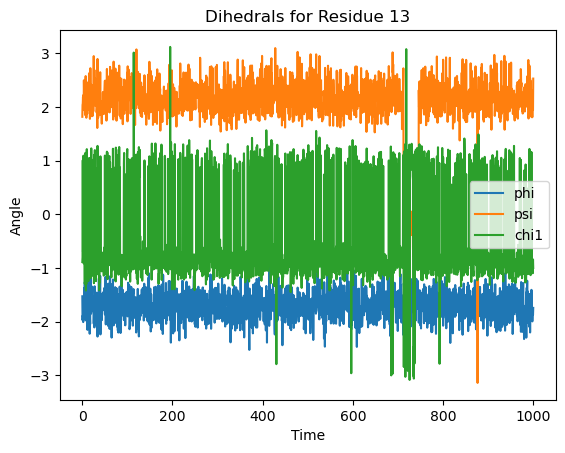

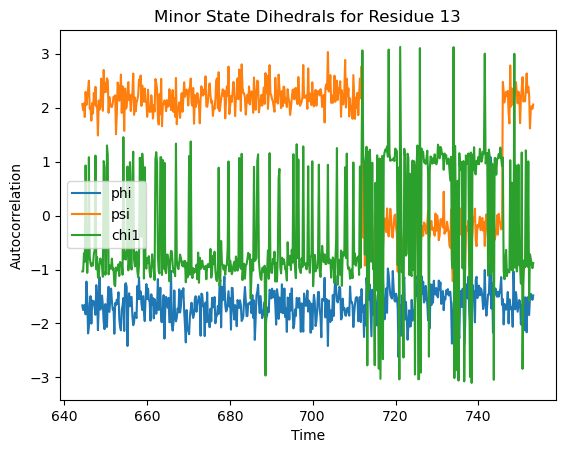

In [101]:
#This will plot the phi, psi, and chi1 values within the frames corresponding to the minor state for a single residue. 

plt.plot(time[1:10088:5],dihedral_dict['phi'][13][1:10088:5], label="phi")
plt.plot(time[1:10088:5],dihedral_dict['psi'][13][1:10088:5], label="psi")
plt.plot(time[1:10088:5],dihedral_dict['chi1'][13][1:10088:5], label="chi1")

plt.xlabel('Time')
plt.ylabel('Angle')
plt.title('Dihedrals for Residue 13')
plt.legend()
plt.show()
#Now just for the minor state. 
plt.plot(time[6500:7600:2],dihedral_dict['phi'][13][6500:7600:2], label="phi")
plt.plot(time[6500:7600:2],dihedral_dict['psi'][13][6500:7600:2], label="psi")
plt.plot(time[6500:7600:2],dihedral_dict['chi1'][13][6500:7600:2], label="chi1")

plt.xlabel('Time')
plt.ylabel('Autocorrelation')
plt.title('Minor State Dihedrals for Residue 13')
plt.legend()
plt.show()

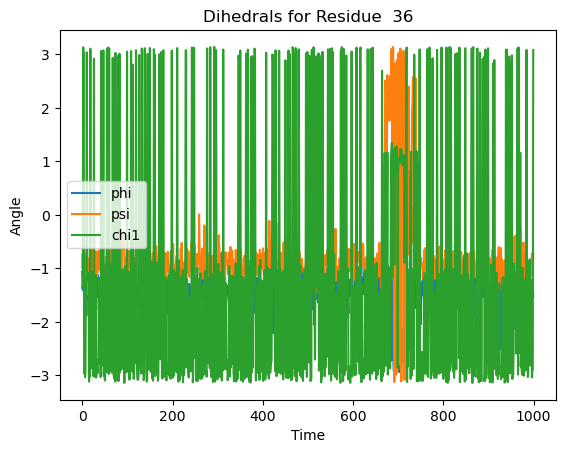

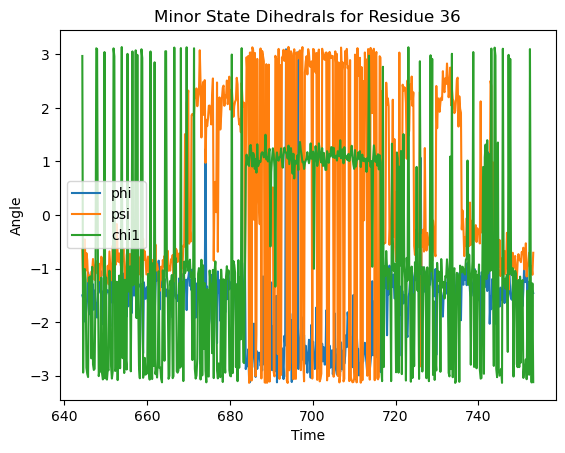

In [122]:
#I did this again for residue 33 because it is in the region of the alpha helix that is destabilized in the minor state. 
plt.plot(time[1:10088:10],dihedral_dict['phi'][33][1:10088:10], label="phi")
plt.plot(time[1:10088:10],dihedral_dict['psi'][33][1:10088:10], label="psi")
plt.plot(time[1:10088:10],dihedral_dict['chi1'][33][1:10088:10], label="chi1")

plt.xlabel('Time')
plt.ylabel('Angle')
plt.title('Dihedrals for Residue  36')
plt.legend()
plt.show()
#Now just for the minor state. 
plt.plot(time[6500:7600:2],dihedral_dict['phi'][33][6500:7600:2], label="phi")
plt.plot(time[6500:7600:2],dihedral_dict['psi'][33][6500:7600:2], label="psi")
plt.plot(time[6500:7600:2],dihedral_dict['chi1'][33][6500:7600:2], label="chi1")

plt.xlabel('Time')
plt.ylabel('Angle')
plt.title('Minor State Dihedrals for Residue 36')
plt.legend()
plt.show()

In [118]:
#This loop within a loop will allow me to sort out residues that have very high autocorrelatiom times overall. 
all_dihe_high_auto_corr_arry = []
for angle in auto_corr_time_dict.keys(): 
    high_auto_corr_arr = []
    residues = list(auto_corr_time_dict[angle].keys())
    for residue in residues:
        # if autocorrelation time is higher than 0.4, 
        auto_corr_t = auto_corr_time_dict[angle][residue]
        if auto_corr_t > 0.2:
            # store to the high_auto_corr_arr array 
            high_auto_corr_arr.append((auto_corr_t, residue, angle))
    all_dihe_high_auto_corr_arry.append(high_auto_corr_arr)

In [119]:
#This will sort out residues that have high autocorrelation times in minor state only. 
all_dihe_high_auto_corr_minor_arry = []
for angle in auto_corr_time_minor_dict.keys(): 
    high_auto_corr_arr = []
    residues = list(auto_corr_time_minor_dict[angle].keys())
    for residue in residues:
        # if autocorrelation time is higher than 0.4, 
        auto_corr_t = auto_corr_time_minor_dict[angle][residue]
        if auto_corr_t > 0.2:
            # store to the high_auto_corr_arr array 
            high_auto_corr_arr.append((auto_corr_t, residue, angle))
    all_dihe_high_auto_corr_minor_arry.append(high_auto_corr_arr)

In [120]:
all_dihe_high_auto_corr_arry

[[(0.31167247140596144, 10, 'phi'),
  (0.4081468080457403, 35, 'phi'),
  (0.20593842067146265, 40, 'phi'),
  (0.23872125705633443, 53, 'phi'),
  (0.7079869310209886, 60, 'phi')],
 [(0.22923484897405458, 8, 'psi'),
  (0.2694838933110503, 9, 'psi'),
  (0.3157774535764167, 13, 'psi'),
  (0.9356843664799083, 30, 'psi'),
  (0.8458091488242324, 31, 'psi'),
  (0.338658594711244, 32, 'psi'),
  (0.38839833544208446, 34, 'psi'),
  (0.21856565415383036, 39, 'psi'),
  (0.2349213425924991, 51, 'psi'),
  (0.20704183417254632, 52, 'psi'),
  (0.21861949068782943, 59, 'psi')],
 [],
 [(0.6961704859058081, 59, 'chi2')]]

In [121]:
all_dihe_high_auto_corr_minor_arry

[[(0.21816746793225958, 8, 'phi'),
  (0.6516115065852919, 10, 'phi'),
  (0.26311456509093994, 35, 'phi'),
  (0.2556297278826349, 53, 'phi')],
 [(0.40119183972059685, 8, 'psi'),
  (0.4118016119218874, 9, 'psi'),
  (2.114648555934401, 13, 'psi'),
  (1.1951348283348038, 30, 'psi'),
  (1.0219512019407715, 31, 'psi'),
  (0.3141057894721307, 32, 'psi'),
  (0.31562025102621616, 34, 'psi'),
  (0.2643863273734726, 36, 'psi')],
 [],
 [(0.8349272631737346, 59, 'chi2')]]

Residues ILE 13 and ILE 36 have large changes in their dihedral angles and autocorrelation times due to secondary stucture changes when going from the major state to the minor state. ILE 13 is in the bent portion of the affected beta sheet while ILE 36 is in the destabilized region of the alpha helix meaning both residues are dynamic and have greater degrees of freedom. For example, ILE 13 (pink) and the beta sheet in minor state is shown below in strided across every 100 frames of the minor state. 

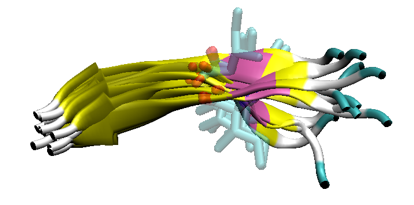

**4) Calculate the ciruclar correlation coefficients between phi and psi angles and reproduce the correlation map from below**  -Look into using a "mask" to eliminate some entries in the correlation matrix and make your plot prettier.

Here is the equation used to calculate circular correlation coefficients for dihedral angles

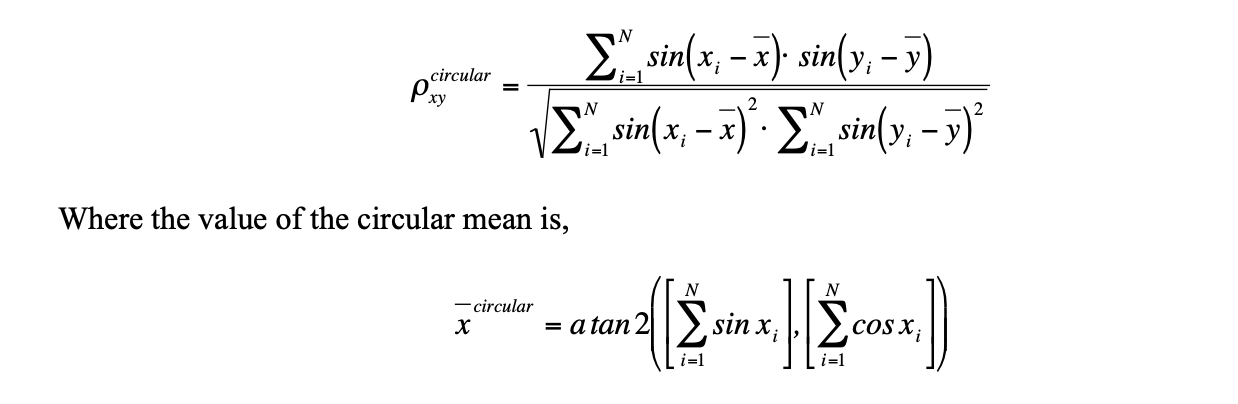


In [125]:
#Calculate circular correlation
def circular_mean(angle):
    return np.arctan2(np.sum(np.sin(angle)),np.sum(np.cos(angle)))


def circular_corr(angle1,angle2):
    cmean1=circular_mean(angle1)
    cmean2=circular_mean(angle2)
    numerator=(np.sum(np.sin(angle1-cmean1)*np.sin(angle2-cmean2)))
    denom=((np.sum(np.sin(angle1-cmean1)**2)*np.sum(np.sin(angle2-cmean2)**2))**.5)
    ccor=numerator/denom
    return ccor

# Make correlation contact map
correlation_maps = []
for i in range(2, 76):
    cor_map = []
    for j in range(2, 76):
        phi=dihedral_dict['phi'][i]
        psi=dihedral_dict['psi'][j]
        ccor=circular_corr(psi,phi)
        cor_map.append(ccor)
    correlation_maps.append(cor_map)
final_cor_map = np.asarray(correlation_maps).astype(float)
np.shape(final_cor_map)

(74, 74)

In [126]:
#This stores residues to the sequence array, and then truncates this sequence to pull every 3rd residue. This will be useful when plotting later. 
sequence=[]
for residue in trj.topology.residues:
   sequence.append(residue)
len(sequence)
#Lets Zero Out some of the Labels 
seq_trunc=sequence[1:76]

n=3
for i in range (0,75): 
  if (i % n !=0):
   seq_trunc[i]=''
print(sequence)
print(seq_trunc)


[MET1, GLN2, ILE3, PHE4, VAL5, LYS6, THR7, LEU8, THR9, GLY10, LYS11, THR12, ILE13, THR14, LEU15, GLU16, VAL17, GLU18, PRO19, SER20, ASP21, THR22, ILE23, GLU24, ASN25, VAL26, LYS27, ALA28, LYS29, ILE30, GLN31, ASP32, LYS33, GLU34, GLY35, ILE36, PRO37, PRO38, ASP39, GLN40, GLN41, ARG42, LEU43, ILE44, PHE45, ALA46, GLY47, LYS48, GLN49, LEU50, GLU51, ASP52, GLY53, ARG54, THR55, LEU56, SER57, ASP58, TYR59, ASN60, ILE61, GLN62, LYS63, GLU64, SER65, THR66, LEU67, HIS68, LEU69, VAL70, LEU71, ARG72, LEU73, ARG74, GLY75, GLY76]
[GLN2, '', '', VAL5, '', '', LEU8, '', '', LYS11, '', '', THR14, '', '', VAL17, '', '', SER20, '', '', ILE23, '', '', VAL26, '', '', LYS29, '', '', ASP32, '', '', GLY35, '', '', PRO38, '', '', GLN41, '', '', ILE44, '', '', GLY47, '', '', LEU50, '', '', GLY53, '', '', LEU56, '', '', TYR59, '', '', GLN62, '', '', SER65, '', '', HIS68, '', '', LEU71, '', '', ARG74, '', '']


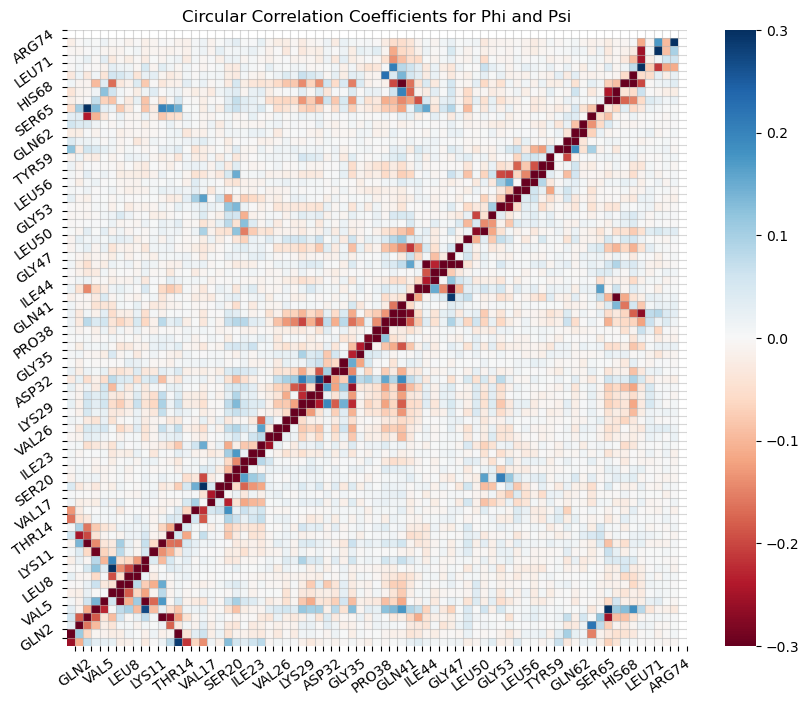

In [129]:
#This plots our circular correlations. I have adjusted the color scheme, residue spacing, and have masked to make it look similar to the figure in the paper. 
mask = np.zeros_like(final_cor_map)
zeros=np.where((final_cor_map<0.10) & (final_cor_map>-0.10))
mask[zeros] = True
plt.figure(figsize=(10, 8)) 
ax = sns.heatmap(final_cor_map, vmin=-0.3, vmax=0.3,cmap='RdBu')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(1,76))
ax.set_yticks(range(1,76))
ax.set_xticklabels(seq_trunc,rotation=36)
ax.set_yticklabels(seq_trunc,rotation=36)
ax.set_title('Circular Correlation Coefficients for Phi and Psi')
plt.show()

5) Make a 2D map showing the populations of hydrogen bonds between different residues.

In [249]:
hbonds = md.baker_hubbard(trj, periodic=False)
label = lambda hbond : '%s -- %s' % (trj.topology.atom(hbond[0]), trj.topology.atom(hbond[2]))
for hbond in hbonds:
    print(label(hbond))

MET1-N -- VAL17-O
MET1-N -- VAL17-O
MET1-N -- VAL17-O
ILE3-N -- LEU15-O
PHE4-N -- SER65-O
VAL5-N -- ILE13-O
LYS6-N -- LEU67-O
THR7-N -- LYS11-O
LEU8-N -- THR7-OG1
LEU8-N -- LEU69-O
THR9-N -- THR7-OG1
GLY10-N -- THR7-O
LYS11-N -- THR7-OG1
LYS11-NZ -- GLU34-OE1
LYS11-NZ -- GLU34-OE2
LYS11-NZ -- GLU34-OE1
LYS11-NZ -- GLU34-OE2
LYS11-NZ -- GLU34-OE1
LYS11-NZ -- GLU34-OE2
ILE13-N -- VAL5-O
LEU15-N -- ILE3-O
VAL17-N -- MET1-O
GLU18-N -- ASP21-OD1
GLU18-N -- ASP21-OD2
ASP21-N -- GLU18-O
THR22-N -- ASN25-OD1
ILE23-N -- ARG54-O
GLU24-N -- ASP52-O
ASN25-N -- THR22-OG1
ASN25-N -- THR22-O
ASN25-ND2 -- THR22-OG1
ASN25-ND2 -- THR22-OG1
VAL26-N -- THR22-O
VAL26-N -- ILE23-O
LYS27-N -- ILE23-O
LYS27-NZ -- GLN41-O
LYS27-NZ -- ASP52-OD1
LYS27-NZ -- ASP52-OD2
LYS27-NZ -- GLN41-O
LYS27-NZ -- ASP52-OD1
LYS27-NZ -- ASP52-OD2
LYS27-NZ -- GLN41-O
LYS27-NZ -- ASP52-OD1
LYS27-NZ -- ASP52-OD2
ALA28-N -- GLU24-O
LYS29-N -- ASN25-O
LYS29-N -- VAL26-O
ILE30-N -- VAL26-O
ILE30-N -- LYS27-O
GLN31-N -- LYS27-O
ASP32-N

In [280]:
np.shape(hbonds)

(114, 3)

In [263]:
for hbond in hbonds:
 donor = top.atom(hbond[0])
 acc = top.atom(hbond[2])
 print(hbond,donor,acc)

[  0   1 285] MET1-N VAL17-O
[  0   2 285] MET1-N VAL17-O
[  0   3 285] MET1-N VAL17-O
[ 36  37 254] ILE3-N LEU15-O
[  55   56 1044] PHE4-N SER65-O
[ 75  76 221] VAL5-N ILE13-O
[  91   92 1077] LYS6-N LEU67-O
[113 114 188] THR7-N LYS11-O
[127 128 119] LEU8-N THR7-OG1
[ 127  128 1113] LEU8-N LEU69-O
[146 147 119] THR9-N THR7-OG1
[160 161 126] GLY10-N THR7-O
[167 168 119] LYS11-N THR7-OG1
[183 184 551] LYS11-NZ GLU34-OE1
[183 184 552] LYS11-NZ GLU34-OE2
[183 185 551] LYS11-NZ GLU34-OE1
[183 185 552] LYS11-NZ GLU34-OE2
[183 186 551] LYS11-NZ GLU34-OE1
[183 186 552] LYS11-NZ GLU34-OE2
[203 204  90] ILE13-N VAL5-O
[236 237  54] LEU15-N ILE3-O
[270 271  18] VAL17-N MET1-O
[286 287 334] GLU18-N ASP21-OD1
[286 287 335] GLU18-N ASP21-OD2
[326 327 300] ASP21-N GLU18-O
[338 339 394] THR22-N ASN25-OD1
[352 353 869] ILE23-N ARG54-O
[371 372 838] GLU24-N ASP52-O
[386 387 344] ASN25-N THR22-OG1
[386 387 351] ASN25-N THR22-O
[395 396 344] ASN25-ND2 THR22-OG1
[395 397 344] ASN25-ND2 THR22-OG1
[400 401 

In [9]:
#HW 5 #this is my best attempt, but its not quite right. 
import mdtraj as md
import numpy as np

# Get the number of residues
num_residues = trj.n_residues

# Get the number of frames
frames = np.arange(0,trj.n_frames)

# Initialize a square matrix to store the count of hydrogen bonds for each residue
hbond_population_matrix = np.zeros((num_residues, num_residues, trj.n_frames), dtype=int)

# Iterate over each frame
for frame in frames:
    # Calculate the hydrogen bonds for the current frame
    hbonds = md.baker_hubbard(trj[frame], periodic=False)
    
    # Iterate over each hydrogen bond in the current frame
    for hbond in hbonds:
        # Get the donor and acceptor atoms
        donor_index = hbond[0]
        acceptor_index = hbond[2]
        
        # Initialize variables to store donor and acceptor residues
        donor_residue = None
        acceptor_residue = None
        
        # Iterate over each residue to find the donor and acceptor residues
        for residue in trj.topology.residues:
            # Check if the donor atom belongs to this residue
            if donor_index in [atom.index for atom in residue.atoms]:
                donor_residue = residue.index
                
            # Check if the acceptor atom belongs to this residue
            if acceptor_index in [atom.index for atom in residue.atoms]:
                acceptor_residue = residue.index

        # Increment the count in the matrix if both donor and acceptor residues are found
        if donor_residue is not None and acceptor_residue is not None:
            hbond_population_matrix[donor_residue, acceptor_residue, frame] += 1
            hbond_population_matrix[acceptor_residue, donor_residue, frame] += 1


hbond_population_matrix = (np.where(hbond_population_matrix > 0, 1, 0))
hbond_population_matrix = hbond_population_matrix/trj.n_frames

print(hbond_population_matrix)
print(acceptor_index)
print(donor_residue)
print(acceptor_residue)
print(frames)
print (hbonds[30])

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
996
64
61


In [91]:
sequence=[]
for residue in trj.topology.residues:
   sequence.append(residue)
len(sequence)
#Lets Zero Out some of the Labels 
seq_trunc=sequence[1:76]

n=3
for i in range (0,75): 
  if (i % n !=0):
   seq_trunc[i]=''
print(sequence)
print(seq_trunc)

[MET1, GLN2, ILE3, PHE4, VAL5, LYS6, THR7, LEU8, THR9, GLY10, LYS11, THR12, ILE13, THR14, LEU15, GLU16, VAL17, GLU18, PRO19, SER20, ASP21, THR22, ILE23, GLU24, ASN25, VAL26, LYS27, ALA28, LYS29, ILE30, GLN31, ASP32, LYS33, GLU34, GLY35, ILE36, PRO37, PRO38, ASP39, GLN40, GLN41, ARG42, LEU43, ILE44, PHE45, ALA46, GLY47, LYS48, GLN49, LEU50, GLU51, ASP52, GLY53, ARG54, THR55, LEU56, SER57, ASP58, TYR59, ASN60, ILE61, GLN62, LYS63, GLU64, SER65, THR66, LEU67, HIS68, LEU69, VAL70, LEU71, ARG72, LEU73, ARG74, GLY75, GLY76]
[GLN2, '', '', VAL5, '', '', LEU8, '', '', LYS11, '', '', THR14, '', '', VAL17, '', '', SER20, '', '', ILE23, '', '', VAL26, '', '', LYS29, '', '', ASP32, '', '', GLY35, '', '', PRO38, '', '', GLN41, '', '', ILE44, '', '', GLY47, '', '', LEU50, '', '', GLY53, '', '', LEU56, '', '', TYR59, '', '', GLN62, '', '', SER65, '', '', HIS68, '', '', LEU71, '', '', ARG74, '', '']


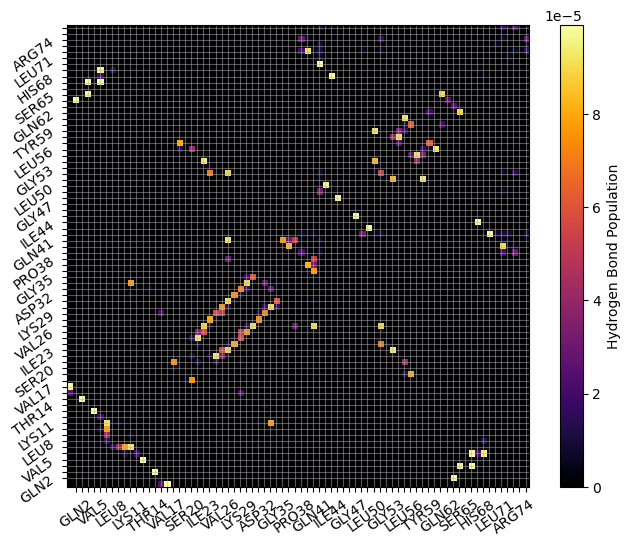

In [95]:

import matplotlib.pyplot as plt
def plot_hbond_map(hbond_matrix):
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(hbond_matrix, cmap='inferno', interpolation='nearest')
    ax.figure.colorbar(im, ax=ax, label='Hydrogen Bond Population')
    ax.set_xticks(range(1,76))
    ax.set_yticks(range(1,76))
    ax.set_xticklabels(seq_trunc,rotation=36)
    ax.set_yticklabels(seq_trunc,rotation=36)
    ax.invert_yaxis()
    ax.grid(which='both', alpha=0.5)
    plt.show()

# Example usage
plot_hbond_map(np.average(hbond_population_matrix, axis=2))

# Show the plot
plt.show()

This plot aligns nicely with the circular correlation plot, as well as spots on the contact map.  This makes sense as residies that interact over most of the frames will be correlated, and must be in close proximity to have hydrogen bonds. 

Lets calculate some correlations between dihedrals found in the paper: 


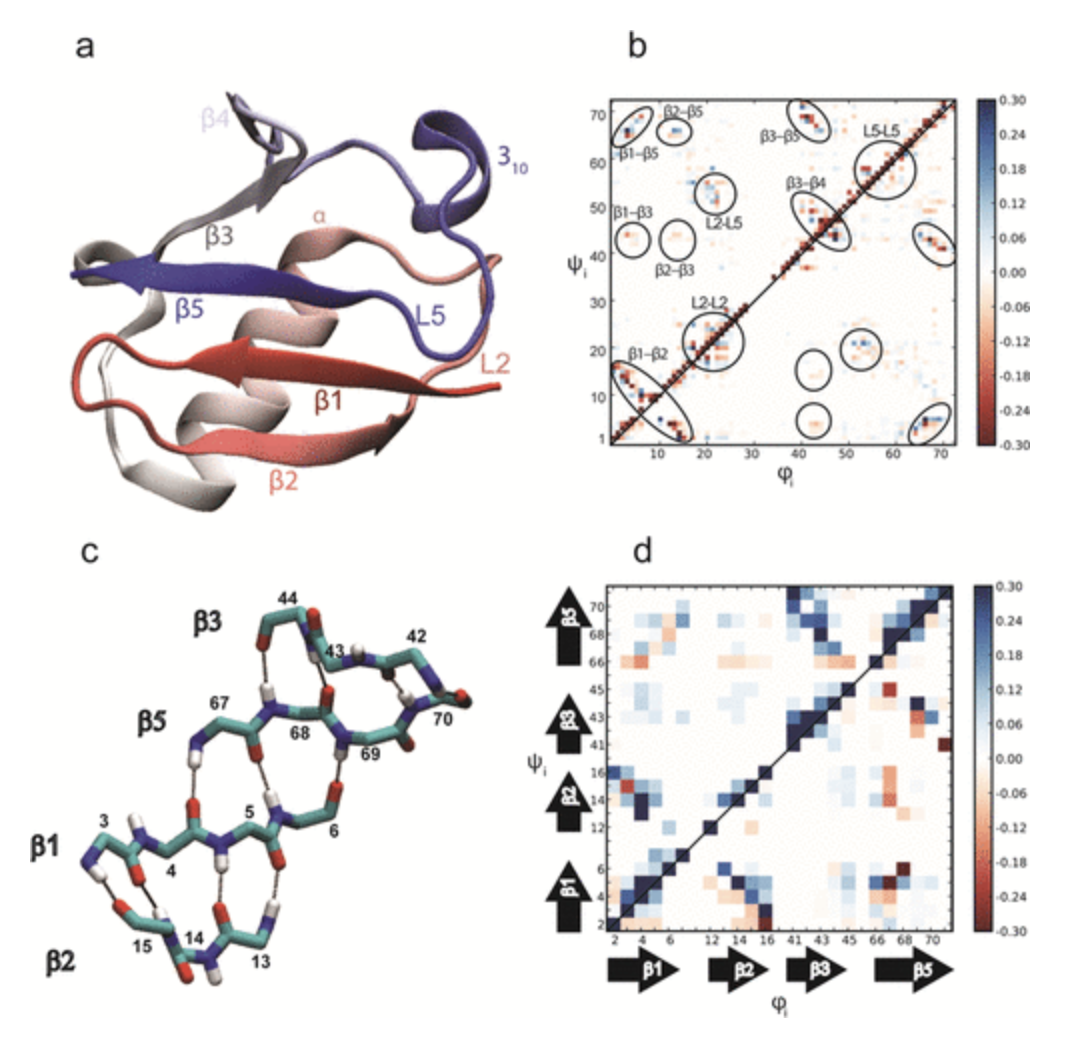